In [2]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import datetime as dt

from factor_momentum import assetspace_signal_monthly

from sf_quant.data import load_factors

/home/boobus/projects/factor_momentum/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-20 11:12:11,759	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
TYPE = 'rolling continuous'

In [ ]:
start = dt.date(2000,1,1)
end = dt.date(2020,1,1)

monthly_signal = assetspace_signal_monthly(start=start, end=end, type=TYPE)
monthly_signal

month,barrid,ret,market_cap,signal
date,str,f64,f64,f64
2013-07-01,"""USA06Z1""",-0.001596,6.006157e8,-0.188481
2013-08-01,"""USA06Z1""",-0.014481,5.9463375e8,-0.059871
2013-09-01,"""USA06Z1""",-0.391781,4.0188375e8,-0.062705
2013-10-01,"""USA06Z1""",0.23979,5.174708e8,-0.017102
2013-11-01,"""USA06Z1""",0.172845,6.071625e8,0.103536
…,…,…,…,…
2019-12-01,"""USBEVY1""",0.038019,6.0276e8,-0.190582
2019-12-01,"""USBEWD1""",0.007976,2.0000e8,-0.18278
2019-12-01,"""USBEWE1""",-0.030714,3.6251e8,-0.125273


In [80]:
monthly_signal = (monthly_signal.with_columns(
    (pl.col('ret') * pl.col('market_cap')/pl.col('market_cap').sum().over('month')).alias('wret')
)
)

In [81]:
benchmark = monthly_signal.group_by(['month']).agg(
    pl.col('wret').mean()
).sort('month')

benchmark

month,wret
date,f64
2001-01-01,0.000018
2001-02-01,-0.00003
2001-03-01,-0.000022
2001-04-01,0.000031
2001-05-01,0.000004
…,…
2019-08-01,-0.000006
2019-09-01,0.000006
2019-10-01,0.000008


In [82]:
binned = (monthly_signal.with_columns(
    pl.col('signal').rank('dense').over('month').alias('rank')
)
.with_columns(
    (pl.lit("p") +
    (pl.col('rank')/pl.col('rank').count().over('month')*10 - 0.0001)
    .floor()
    .cast(pl.Int32).cast(pl.Utf8))
    .alias('bin')
)
.group_by(['month', 'bin']).agg(
    pl.col('ret').mean().alias('ret'),
    pl.col('wret').count().alias('count'),
    pl.col('market_cap').sum()
)
.sort(['bin', 'month'])
.with_columns(
    (pl.col('ret') * pl.col('market_cap') / pl.col('market_cap').sum().over('month')).alias('wret')
)
)

ports_ew = (binned
.pivot(on='bin', index='month', values='ret')
.drop_nulls()
)

ports_vw = (binned
.pivot(on='bin', index='month', values='wret')
.drop_nulls()
)

ports_vw

month,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01,0.004603,0.010486,0.025223,0.025639,0.015545,0.006265,0.002617,0.001705,0.001682,0.000846
2001-02-01,-0.002796,-0.012251,-0.03883,-0.0488,-0.010053,-0.005364,-0.001355,-0.001277,-0.000086,0.000413
2001-03-01,-0.001689,-0.005245,-0.016327,-0.016802,-0.015553,-0.006404,-0.002002,-0.001882,-0.001394,-0.00093
2001-04-01,0.000052,0.008373,0.021564,0.030521,0.012938,0.006068,0.004771,0.002607,0.001816,0.001566
2001-05-01,-0.000172,-0.000775,0.000287,-0.002284,0.006754,0.002595,0.001969,0.001669,0.000741,0.000512
…,…,…,…,…,…,…,…,…,…,…
2019-08-01,-0.000866,-0.001037,-0.0009,-0.00096,-0.00163,-0.003159,-0.003031,-0.003742,-0.00248,0.009948
2019-09-01,0.000081,0.000101,0.000196,0.000473,0.000629,0.001353,0.001955,0.003036,0.005602,0.005455
2019-10-01,-0.000272,-0.000186,0.00016,0.000437,0.000695,0.001263,0.001848,0.001632,0.006125,0.002492


In [83]:
plt.style.use('default')

def plot_deciles(df, name, cum_sum=True, long=False):
    if long:
        plt.figure(figsize=(12, 3))
    else:
        plt.figure(figsize=(7, 5))
    plt.title(name)
    plt.grid(True)
    dates = df['month']

    for i in range(10):
        if cum_sum:
            plt.plot(dates, df[f'p{i}'].cum_sum(),label = f'p{i}')
        else:
            plt.plot(dates, df[f'p{i}'],label = f'p{i}')
            
    plt.legend()
    plt.show()

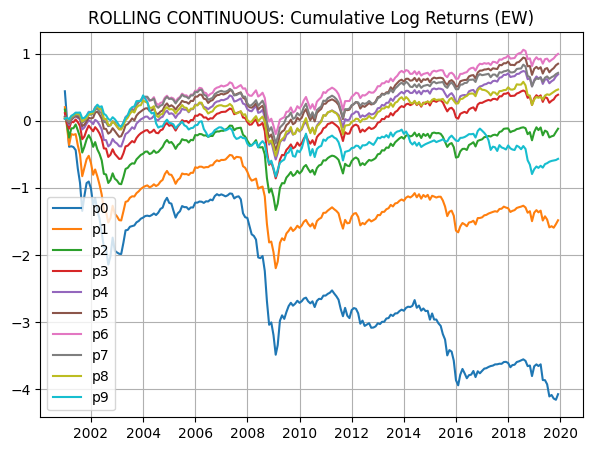

In [84]:
plot_deciles(ports_ew, f"{TYPE.upper()}: Cumulative Log Returns (EW)")

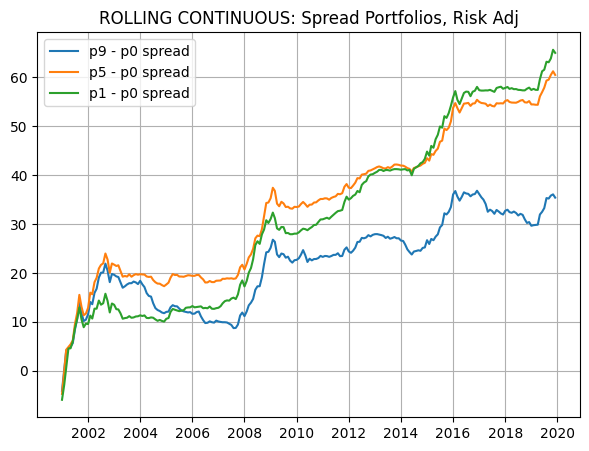

In [85]:
dates = ports_ew['month']

plt.figure(figsize=(7, 5))
plt.title(f'{TYPE.upper()}: Spread Portfolios, Risk Adj')

plt.grid(True)

s9 = (ports_ew['p9'] - ports_ew['p0'])
s5 = (ports_ew['p5'] - ports_ew['p0'])
s1 = (ports_ew['p1'] - ports_ew['p0'])

plt.plot(dates, s9.cum_sum()/s9.std(), label='p9 - p0 spread')
plt.plot(dates, s5.cum_sum()/s5.std(), label='p5 - p0 spread')
plt.plot(dates, s1.cum_sum()/s1.std(), label='p1 - p0 spread')
plt.legend()


plt.show()

In [86]:
def Sharpe(df, name):
    annual_ret =  df.mean() * 12
    annual_vol = (df).std() * np.sqrt(12)
    sharpe = annual_ret / annual_vol

    print(
        f'{name}: \n'
        f'  Annual Return: {annual_ret:.2f} | '
        f'Annual Vol: {annual_vol:.2f} | '
        f'Sharpe: {sharpe:.2f}'
    )

Sharpe(s9, 'Spread 9')
Sharpe(s5, 'Spread 5')
Sharpe(s1, 'Spread 1')

Spread 9: 
  Annual Return: 0.18 | Annual Vol: 0.34 | Sharpe: 0.54
Spread 5: 
  Annual Return: 0.26 | Annual Vol: 0.28 | Sharpe: 0.92
Spread 1: 
  Annual Return: 0.14 | Annual Vol: 0.14 | Sharpe: 0.99


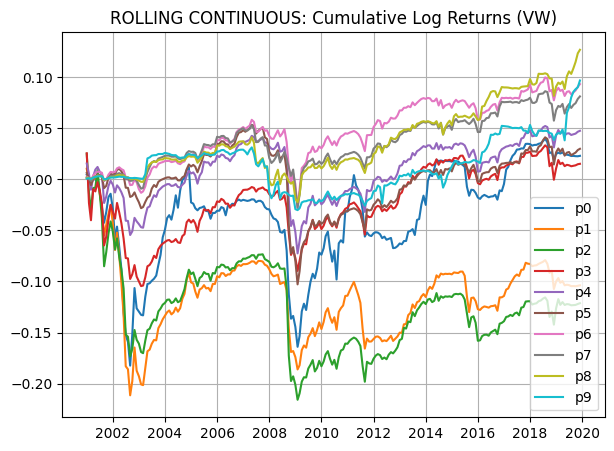

In [87]:
plot_deciles(ports_vw, f"{TYPE.upper()}: Cumulative Log Returns (VW)")

In [88]:
mes = (binned
.pivot(on='bin', index='month', values='market_cap')
.drop_nulls()
)

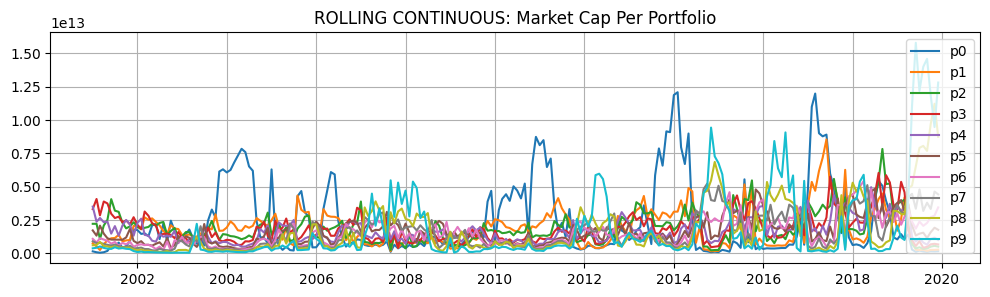

In [89]:
plot_deciles(mes, f'{TYPE.upper()}: Market Cap Per Portfolio', False, True)

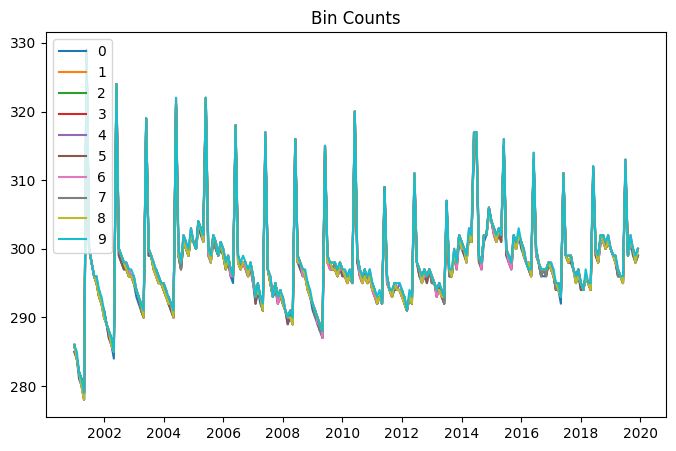

In [90]:
dates = ports_vw['month']
counts = (binned.pivot(
    on='bin', index='month', values='count'
)
)

plt.figure(figsize=(8, 5))
plt.title("Bin Counts")

for i in range(10):
    plt.plot(dates, counts[f'p{i}'], label = f'{i}')

plt.legend()
plt.show()

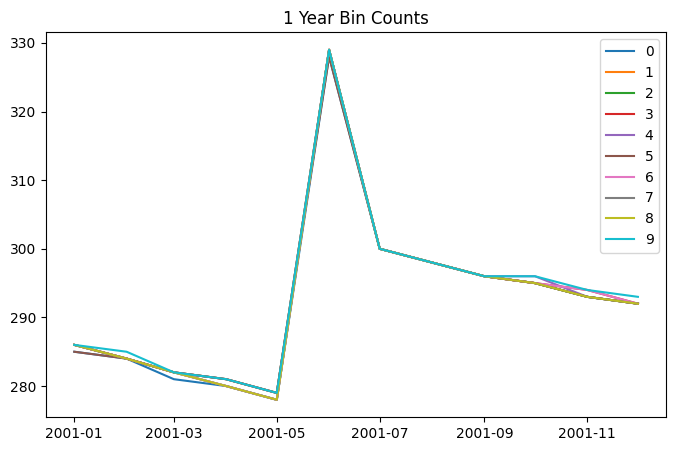

In [91]:
plt.figure(figsize=(8, 5))
plt.title("1 Year Bin Counts")

for i in range(10):
    plt.plot(dates[:12], counts[f'p{i}'][:12], label = f'{i}')

plt.legend()
plt.show()